In [7]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import sys
import time
import datetime
from scipy.optimize import curve_fit

from file_read_backwards import FileReadBackwards

PMT_num = 1107
testing = 0
bins = 1000
range_uw = 1000
epoch_size = 10000000
Threshold = 40
chunks_num = 500

sampling_events = 100

File_Path = 'PMT'+str(PMT_num)+'_uw.txt'
output_path = 'output/'

In [13]:
#read the .dat file in file_path, with headers 
# Record Length: 1024
# BoardID: 31
# Channel: 0
# Event Number: 0
# Pattern: 0x0000
# Trigger Time Stamp: 131605
# DC offset (DAC): 0x0F5C
#we want to read the Trigger Time Stamp

In [14]:
def cut_file_in_epoch(file_path, outputpath, epoch_size):
    with open(file_path, 'r') as file:
        base_name = file_path.split('.')[0]
        num = 0
        size = 0
        timestamp = 0
        epoch = []
        time_epoch = []

        int_limit = 4294967294
        int_back = 2147483647
        repitition = 0
        time_temp = 0
        time_prev = 0
        for line in file:
            if size < epoch_size:
                if 'Trigger' in line:
                    time_temp = int(line.split(': ')[1].strip())
                    if time_temp < int_back:
                        timestamp = time_temp
                    else:
                        if time_prev - time_temp > 100000:
                            repitition += 1
                        timestamp = repitition * (int_limit - int_back + 1) + time_temp
                    time_prev = time_temp
                if ('Record Length' not in line) and ('BoardID' not in line) and ('Channel' not in line) and ('Event Number' not in line) and ('Pattern' not in line) and ('Trigger Time Stamp' not in line) and ('DC offset' not in line):
                    epoch.append(line)
                    time_epoch.append(str(timestamp)+'\n')
                    timestamp = timestamp + 1
                    size += 1
            else:
                num = num + 1
                size = 0
                epoch_name = outputpath + 'PMT' + str(PMT_num) + '_epoch' + str(num) + '.txt'
                time_stamp_name = outputpath + 'PMT' + str(PMT_num) + '_timestamp_epoch' + str(num) + '.txt'
                with open(epoch_name, 'w') as epoch_file:
                    epoch_file.writelines(epoch)
                print('Epoch file ' + epoch_name + ' has been created.')
                with open(time_stamp_name, 'w') as time_stamp_file:
                    time_stamp_file.writelines(time_epoch)
                print('Timestamp file ' + time_stamp_name + ' has been created.')
                epoch = []
                time_epoch = []
        #if line reaches the end of the file
        if epoch:
            num = num + 1
            epoch_name = outputpath + 'PMT' + str(PMT_num) + '_epoch' + str(num) + '.txt'
            time_stamp_name = outputpath + 'PMT' + str(PMT_num) + '_timestamp_epoch' + str(num) + '.txt'
            with open(epoch_name, 'w') as epoch_file:
                epoch_file.writelines(epoch)
            print('Epoch file ' + epoch_name + ' has been created.')
            with open(time_stamp_name, 'w') as time_stamp_file:
                time_stamp_file.writelines(time_epoch)
            print('Timestamp file ' + time_stamp_name + ' has been created.')
            epoch = []
            time_epoch = []

    print('All epochs have been created.')
    print('Total number of epochs: ' + str(num))
    return num

In [15]:
def trigger_time_stamp(file_path):
    int_limit = 4294967294
    int_back = 2147483647
    repitition = 0
    time_temp = 0
    time_prev = 0
    with open(file_path, 'r') as file:
        lines = file.readlines()
        timestamps = []
        for line in lines:
            if 'Trigger' in line:
                time_temp = int(line.split(': ')[1].strip())
                if time_temp < int_back:
                    timestamp = time_temp
                else:
                    if time_prev - time_temp > 100000000:
                        repitition += 1
                    timestamp = repitition * (int_limit - int_back + 1) + time_temp
                time_prev = time_temp
                timestamps.append(timestamp)
    return timestamps

In [16]:
def split_file_in_chunks(filename, Chunks, outputpath):
    # Split the filename to remove the .dat extension
    base_name = filename.rsplit('.', 1)[0]
    
    # Open the original file in binary mode
    with open(filename, 'r') as file:
        # Get the size of the file in bytes
        file.seek(0, 2)  # Move the cursor to the end of the file
        filesize = file.tell()
        
        # Determine the size of each chunk
        chunk_size = filesize // Chunks
        
        # Return to the start of the file
        file.seek(0)
        
        # Create each chunk
        for i in range(Chunks):
            # Calculate the size for the last chunk
            if i == Chunks - 1:
                chunk_size = filesize - chunk_size * (Chunks - 1)
            
            # Create a new file for this chunk
            chunk_name = outputpath + 'PMT' + str(PMT_num) + '_chunk' + str(i + 1) + '.txt'
            with open(chunk_name, 'w') as chunk:
                # Read the chunk from the original file
                chunk.write(file.read(chunk_size))
                print('Chunk ' + chunk_name + ' has been created.')

In [17]:
def get_baseline(data):
    #get median of first 1000 samples
    baseline = np.median(data[0:1000])
    return baseline

def flip_data(data):
    # flip data
    baseline = get_baseline(data)
    data = baseline - data
    return data

In [18]:
def find_peaks_uw(data, threshold):
    length = len(data)
    print('Finding peaks...')
    print('Threshold:', threshold)
    # find peaks above threshold and higher than the previous and next data points
    peaks = np.where((data > threshold) & (data >= np.roll(data, 1)) & (data >= np.roll(data, -1)) & (data >= np.roll(data, 2)) & (data >= np.roll(data, -2)) & (data >= np.roll(data, 3)) & (data >= np.roll(data, -3)) & (data >= np.roll(data, 4)) & (data >= np.roll(data, -4)))[0]
    #distance between peaks should be larger than 100
    peaks = peaks[np.where(np.diff(peaks) > 100)[0]]
    # find the start and the end of the peaks
    threshold_width = 0.10*data[peaks]
    start = np.zeros(len(peaks), dtype=int)
    end = np.zeros(len(peaks), dtype=int)
   
    #calculate the area of the peaks
    for i in range(len(peaks)):
        start_t = peaks[i]
        end_t = peaks[i]
        while data[start_t] > threshold_width[i]:
            if (start_t == 0):
                break
            else:
                start_t -= 1
        start[i] = start_t
        while data[end_t] > threshold_width[i]:
            if (end_t == length-1):
                break
            else:
                end_t += 1
        end[i] = end_t 
    #only use peaks with width larger than 5 and smaller than 200
    shortest = 5
    longest = 200
    peaks_new = peaks[np.where((end - start > shortest) & (end - start < longest))]
    start_new = start[np.where((end - start > shortest) & (end - start < longest))]
    end_new = end[np.where((end - start > shortest) & (end - start < longest))]
    # find the peak height
    height = data[peaks_new]
    # find the peak width
    width = end_new - start_new
    # find the peak area
    area = np.zeros(len(start_new))
    for i in range(len(start_new)):
        area[i] = np.sum(data[start_new[i]:end_new[i]])
    return peaks_new, start_new, end_new, height, width, area

In [19]:
#Get the time stamp for the first and last sampling_events amount of the data
def get_begin_end_frequency(file_path, sampling_events):
    int_limit = 4294967294
    int_back = 2147483647
    repitition = 0
    time_temp = 0
    time_prev = 0

    timestamps_begin = []
    timestamps_end = []

    events_num = 0
    with open(file_path, 'r') as file:
        while events_num < sampling_events:
            line = file.readline()
            if 'Trigger' in line:
                time_temp = int(line.split(': ')[1].strip())
                if time_temp < int_back:
                    timestamp = time_temp
                else:
                    if time_prev - time_temp > 10000:
                        repitition += 1
                    timestamp = repitition * (int_limit - int_back + 1) + time_temp
                time_prev = time_temp
                timestamps_begin.append(timestamp)
                events_num += 1
    repitition = 0
    time_temp = 0
    time_prev = 0
    events_num = 0  

    #go to the end of the file and read reversely
    with FileReadBackwards(file_path, encoding="utf-8") as file:
        for line in file:
            if 'Trigger' in line:
                time_temp = int(line.split(': ')[1].strip())
                if time_temp < int_back:
                    timestamp = time_temp
                else:
                    if time_temp - time_prev > 10000:
                        repitition += 1
                    timestamp = -repitition * (int_limit - int_back + 1) + time_temp
                time_prev = time_temp
                timestamps_end.append(timestamp)
                events_num += 1
            if events_num == sampling_events:
                break
    
    #reverse the time_stamps_end
    timestamps_end = timestamps_end[::-1]
    
    time_length_begin = timestamps_begin[-1] - timestamps_begin[0]
    time_length_end = timestamps_end[-1] - timestamps_end[0]
    print('time_length_begin:', time_length_begin)
    print('time_length_end:', time_length_end)

    frequency_begin = sampling_events / (time_length_begin * 4 * 10**-9)
    frequency_end = sampling_events / (time_length_end * 4 * 10**-9)

    return frequency_begin, frequency_end, time_length_begin, time_length_end


In [20]:
number_epoch= cut_file_in_epoch(File_Path, output_path, epoch_size)

Epoch file output/PMT1107_epoch1.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch1.txt has been created.
Epoch file output/PMT1107_epoch2.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch2.txt has been created.
Epoch file output/PMT1107_epoch3.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch3.txt has been created.
Epoch file output/PMT1107_epoch4.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch4.txt has been created.
Epoch file output/PMT1107_epoch5.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch5.txt has been created.
Epoch file output/PMT1107_epoch6.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch6.txt has been created.
Epoch file output/PMT1107_epoch7.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch7.txt has been created.
Epoch file output/PMT1107_epoch8.txt has been created.
Timestamp file output/PMT1107_timestamp_epoch8.txt has been created.
Epoch fi

In [2]:
number_epoch = 0
num_epoch = 0
for file in os.listdir(output_path):
    if file.endswith('.txt') and 'epoch' in file:
        num_epoch = int(file.split('epoch')[1].split('.')[0])
        if num_epoch > number_epoch:
            number_epoch = num_epoch

for i in range (number_epoch):
    data = []
    time = []
    peaks = []
    time_peaks = []
    start = []
    end = []
    height = []
    width = []
    area = []

    epoch_file = output_path + 'PMT' + str(PMT_num) + '_epoch' + str(i+1) + '.txt'
    time_file = output_path + 'PMT' + str(PMT_num) + '_timestamp_epoch' + str(i+1) + '.txt'
    with open(epoch_file, 'r') as file:
        data = file.readlines()
    with open(time_file, 'r') as file:
        time = file.readlines()
    data = np.array(data).astype(int)
    time = np.array(time, dtype=np.int64)
    data = flip_data(data)
    peaks, start, end, height, width, area = find_peaks_uw(data, Threshold)
    time_peaks = time[peaks]
    print('Epoch:', i+1)
    print('Number of peaks:', len(peaks))
    #save peaks time and area
    np.savetxt(output_path + 'time_peaks_epoch' + str(i+1) + '.txt', time_peaks, fmt='%d')
    np.savetxt(output_path + 'area_epoch' + str(i+1) + '.txt', area, fmt='%d')


KeyboardInterrupt



i = 52
Peak Area is 134.97 ± 28.40
Peak Sigma is 28
Peak is at 134


<Figure size 2000x1600 with 0 Axes>

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

Text(0.5, 0, 'Peak Area')

Text(0, 0.5, 'Counts')

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(-200.0, 0, '−200'),
  Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200')])

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200'),
  Text(0, 1400.0, '1400')])

Text(0.5, 1.0, 'PMT1107 Peak Area Distribution in Underwater Test')

<Figure size 2000x1600 with 0 Axes>

(array([288., 108.,  90.,  99.,  97., 106., 124., 120., 118., 107.,  70.,
         78., 103.,  69.,  84.,  99., 104., 123.,  92., 131., 108.,  85.,
         84.,  86.,  82.,  89., 107.,  91.,  98.,  99.,  88.,  80.,  87.,
         98.,  96., 107.,  99.,  86., 106., 104.,  97.,  94., 110.,  65.,
        106., 100.,  87., 108.,  99., 106.,  83., 108.,  76., 119., 120.,
        112., 121.,  91.,  99.,  89., 115.,  99.,  78., 106., 126., 133.,
         81., 123., 109., 123.,  89.,  98., 116., 173., 150., 150., 185.,
        173., 178., 185., 158., 179., 149., 147., 169., 159., 163., 161.,
        197., 171., 234., 117., 105.,  88., 104., 107., 141., 132., 114.,
         94., 106., 105.,  99.,  96., 106.,  95., 108.,  95.,  99., 100.,
        113., 125., 130.,  97.,  99., 146., 106., 101.,  87.,  81.,  80.,
        103.,  98., 105., 103., 100.,  89., 127., 116., 114., 116.,  83.,
        112.,  95.,  98.,  90., 120., 123., 114., 119., 137.,  91., 122.,
        105.,  97.,  87.,  96.,  96., 

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Counts')

(array([-2.0e+09,  0.0e+00,  2.0e+09,  4.0e+09,  6.0e+09,  8.0e+09,
         1.0e+10,  1.2e+10,  1.4e+10,  1.6e+10,  1.8e+10]),
 [Text(-2000000000.0, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(2000000000.0, 0, '0.2'),
  Text(4000000000.0, 0, '0.4'),
  Text(6000000000.0, 0, '0.6'),
  Text(8000000000.0, 0, '0.8'),
  Text(10000000000.0, 0, '1.0'),
  Text(12000000000.0, 0, '1.2'),
  Text(14000000000.0, 0, '1.4'),
  Text(16000000000.0, 0, '1.6'),
  Text(18000000000.0, 0, '1.8')])

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350')])

Text(0.5, 1.0, 'PMT1107 Peak Time Distribution in Underwater Test')

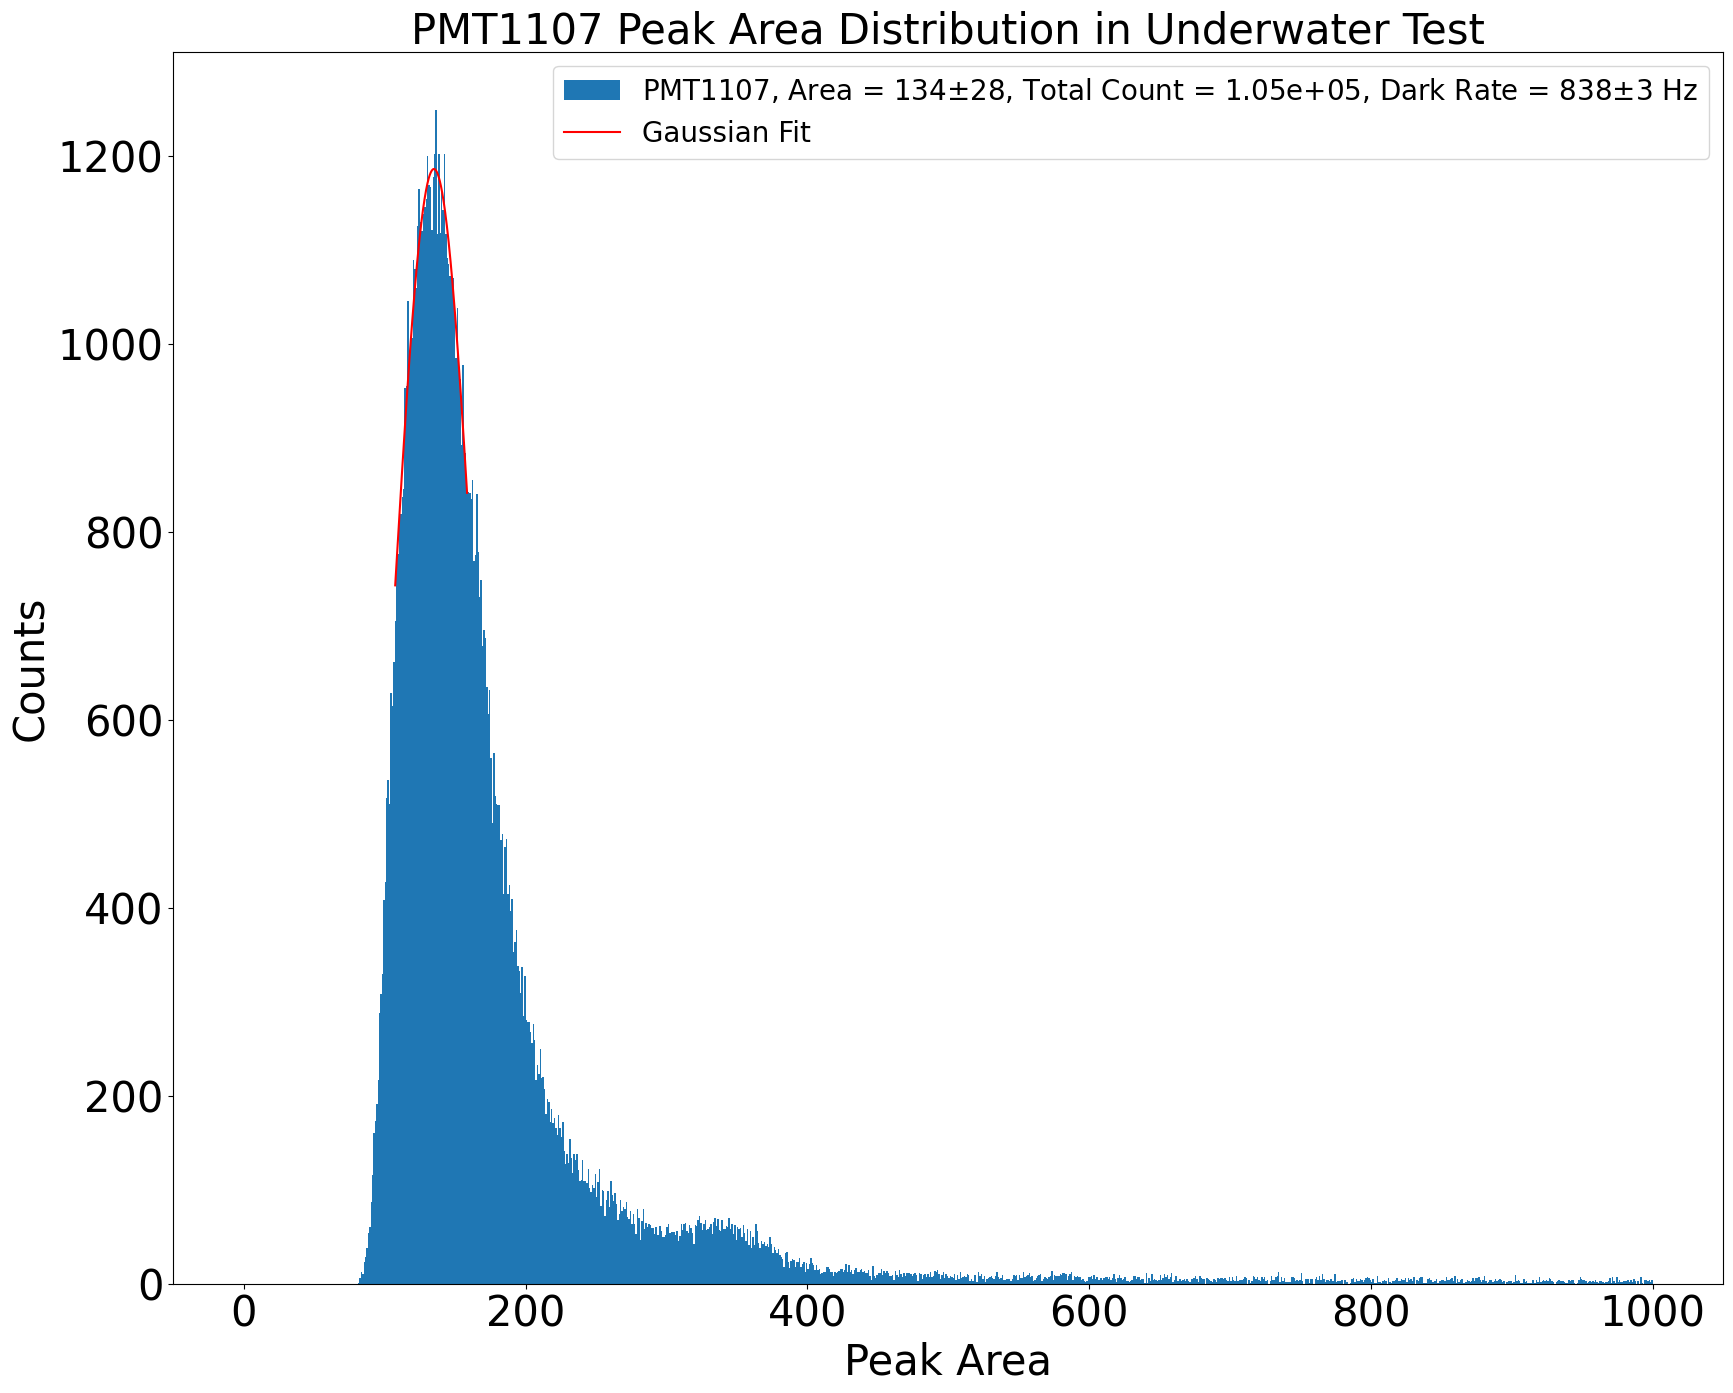

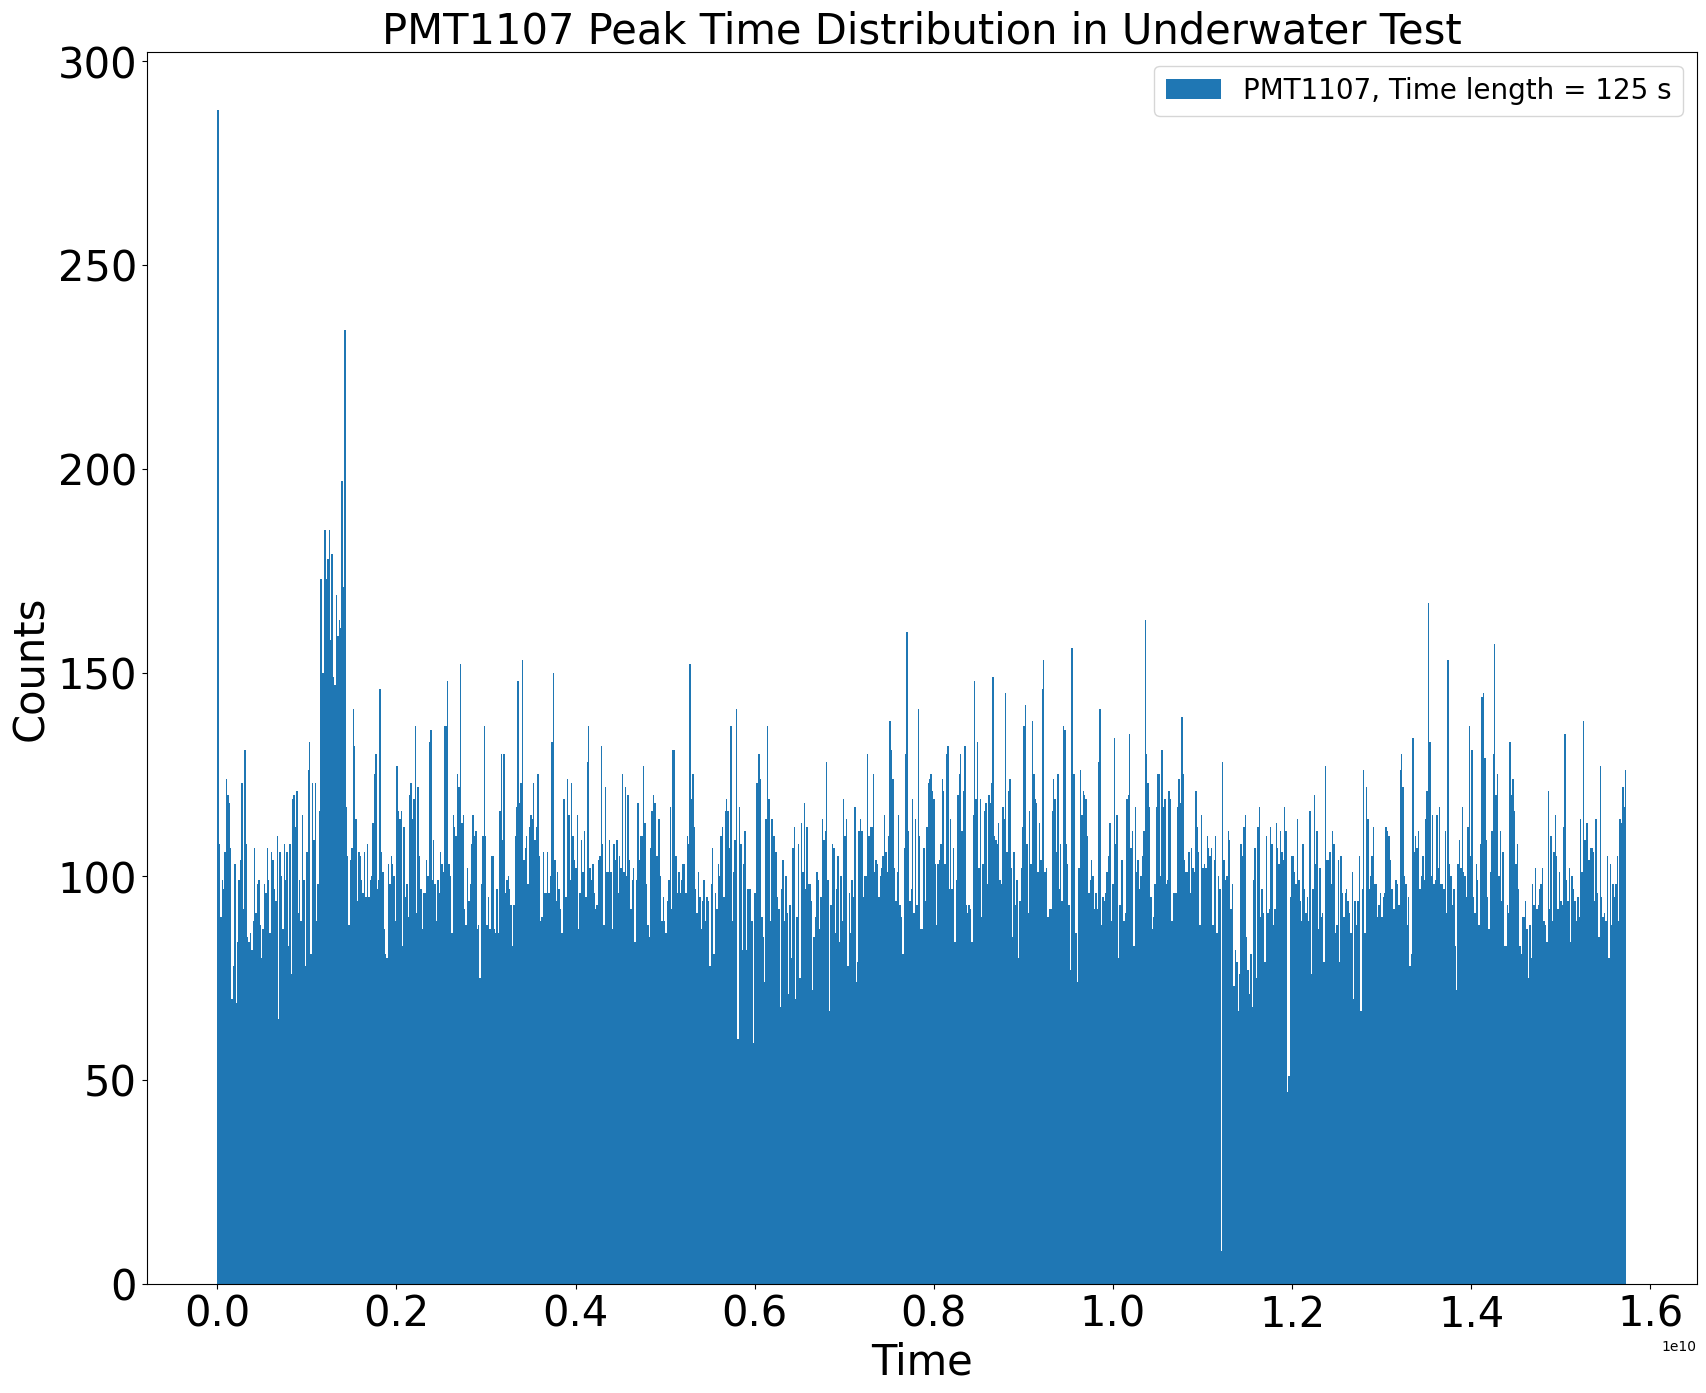

In [3]:
number_epoch = 0
num_epoch = 0
for file in os.listdir(output_path):
    if file.endswith('.txt') and 'epoch' in file:
        num_epoch = int(file.split('epoch')[1].split('.')[0])
        if num_epoch > number_epoch:
            number_epoch = num_epoch


#read all the time and area files
area = []
time = []
area_all = []
time_all = []
for i in range(number_epoch):
    area = np.loadtxt(output_path + 'area_epoch' + str(i+1) + '.txt')
    time = np.loadtxt(output_path + 'time_peaks_epoch' + str(i+1) + '.txt')
    area_all = np.append(area_all, area)
    time_all = np.append(time_all, time)

print ('i =', i)
time_max = np.max(time_all) * 8 * 10**-9
time_min = np.min(time_all) * 8 * 10**-9
time_length = time_max - time_min

#plot the area histogram
hist, binedges = np.histogram(area_all, bins=bins, range=(0, range_uw))
bin_centers = (binedges[:-1] + binedges[1:]) / 2
peak_index = np.where(hist == np.max(hist))[0][0]
peak_area = bin_centers[peak_index]
#gaussian fit the peak of the histogram
left_bound = 0
right_bound = 0
for i in range(peak_index, 0, -1):
    if hist[i] < hist[peak_index]*0.6:
        left_bound = i
        break
for i in range(peak_index, len(hist)):
    if hist[i] < hist[peak_index]*0.7:
        right_bound = i
        break

def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt, pcov = curve_fit(gaussian, bin_centers [left_bound : right_bound], hist[left_bound : right_bound], p0=[np.max(hist), peak_area, 10])

peak_mean = popt[1]
peak_sigma = popt[2]
# print('Peak Area is %d' %peak_mean)
print(f"Peak Area is {peak_mean:.2f} ± {peak_sigma:.2f}")
print('Peak Sigma is %d' %peak_sigma)
Rate_err = np.sqrt(len(area_all))/time_length

print('Peak is at %d' %peak_mean)
plt.figure(figsize=(20, 16))
plt.hist(area_all, bins=bins, range=(0, range_uw), label='PMT%d, Area = %d$\pm$%d, Total Count = ' %(PMT_num, peak_mean,peak_sigma) + f"{float(len(area_all)):.2e}" + ', Dark Rate = ' + f"{float(len(area_all)/time_length):.0f}±{Rate_err:.0f}"+ ' Hz')
x_gauss = np.linspace(bin_centers[left_bound], bin_centers[right_bound], 1000)
plt.plot(x_gauss, gaussian(x_gauss, *popt), 'r-', label='Gaussian Fit')
plt.xlabel('Peak Area', fontsize=30)
plt.ylabel('Counts', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('PMT%d Peak Area Distribution in Underwater Test' %PMT_num, fontsize=30)
plt.legend(fontsize=20)
plt.savefig('PMT' + str(PMT_num) + '_area_distribution.png')

#plot the time histogram
plt.figure(figsize=(20, 16))
plt.hist(time_all, bins=1000, range=(0, max(time_all)), label='PMT%d, Time length = %d s' %(PMT_num, time_length))
plt.xlabel('Time', fontsize=30)
plt.ylabel('Counts', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.title('PMT%d Peak Time Distribution in Underwater Test' %PMT_num, fontsize=30)
plt.savefig('PMT' + str(PMT_num) + '_time_distribution.png')



length of dark_rate: 53
length of dark_rate_err: 53


<Figure size 2000x1200 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Dark Rate (Hz)')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60')])

(array([ 700.,  800.,  900., 1000., 1100., 1200., 1300., 1400.]),
 [Text(0, 700.0, '700'),
  Text(0, 800.0, '800'),
  Text(0, 900.0, '900'),
  Text(0, 1000.0, '1000'),
  Text(0, 1100.0, '1100'),
  Text(0, 1200.0, '1200'),
  Text(0, 1300.0, '1300'),
  Text(0, 1400.0, '1400')])

(700.0, 950.0)

Text(0.5, 1.0, 'PMT1107 Dark Rate Evolution in Underwater Test')

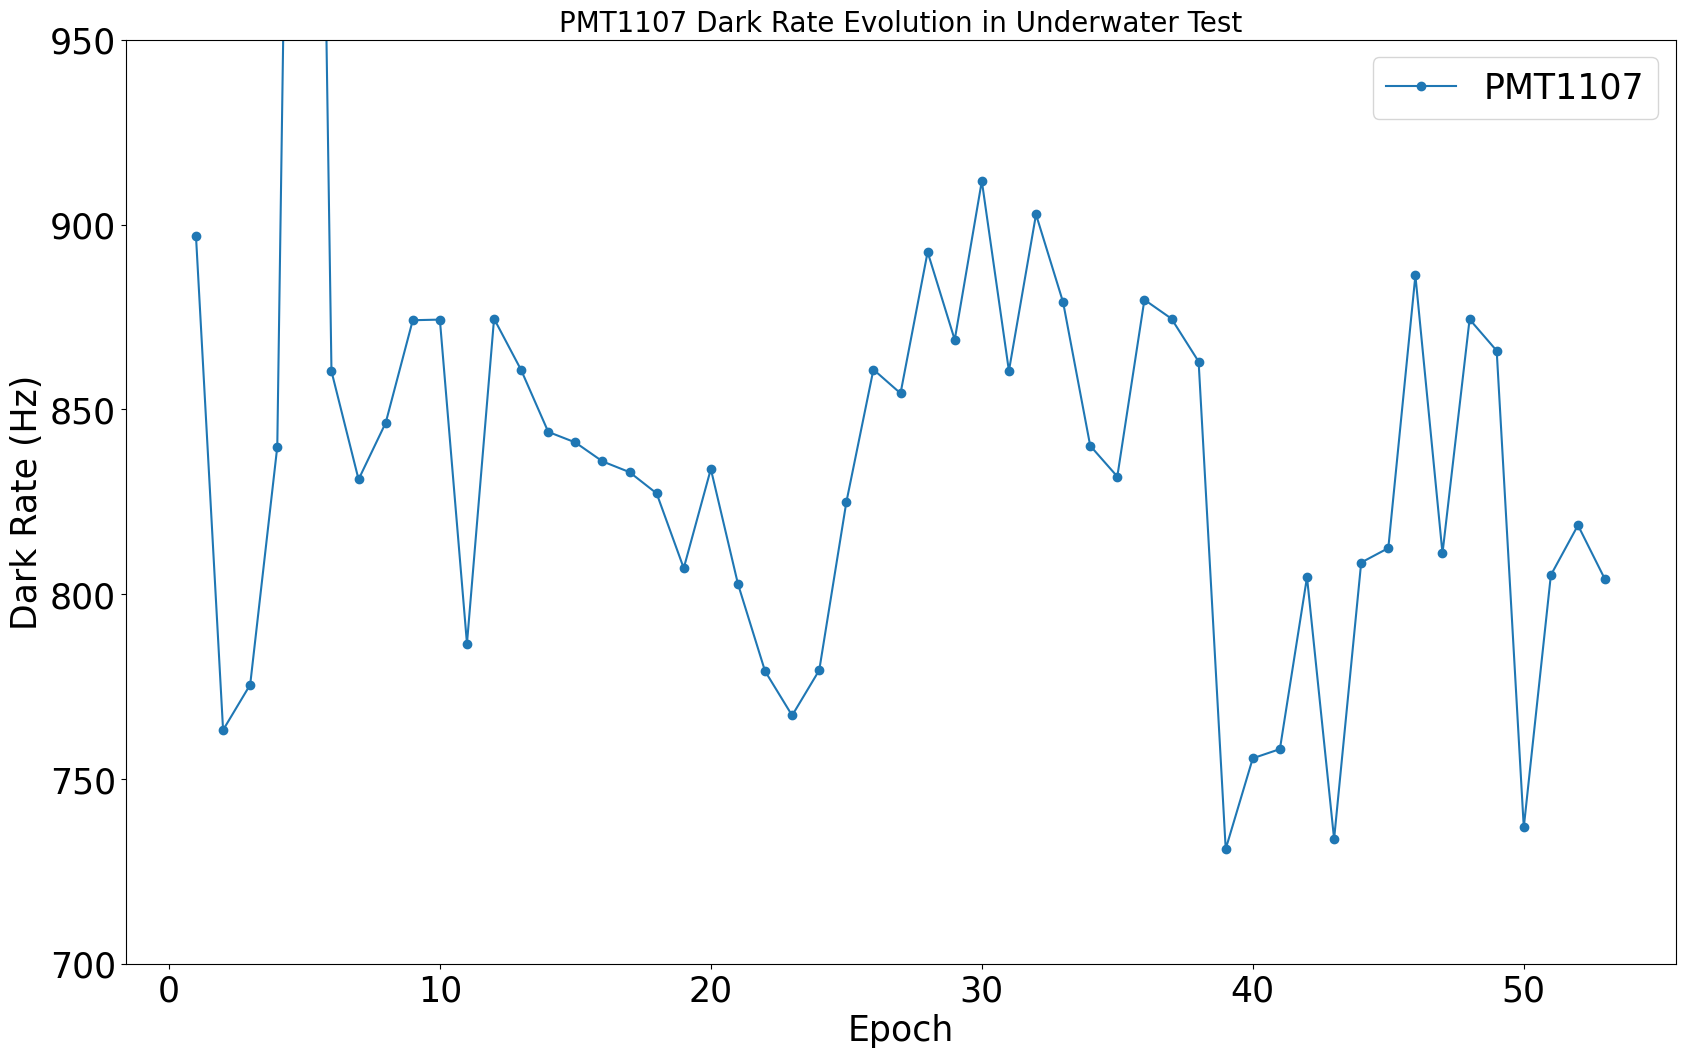

In [13]:
#calculate the dark rate and the error for each epoch, and plot the evolution
number_epoch = 0
num_epoch = 0
for file in os.listdir(output_path):
    if file.endswith('.txt') and 'epoch' in file:
        num_epoch = int(file.split('epoch')[1].split('.')[0])
        if num_epoch > number_epoch:
            number_epoch = num_epoch

dark_rate = []
dark_rate_err = []
time_length = []
for i in range(number_epoch):
    time = np.loadtxt(output_path + 'time_peaks_epoch' + str(i+1) + '.txt')
    time_length = (time[-1] - time[0])*8*10**-9
    rate = len(time) / time_length
    rate_err = np.sqrt(len(time)) / time_length
    dark_rate.append(rate)
    dark_rate_err.append(dark_rate_err)

print('length of dark_rate:', len(dark_rate))
print('length of dark_rate_err:', len(dark_rate_err))

plt.figure(figsize=(20, 12))
plt.plot(range(1, number_epoch+1), dark_rate, 'o-', label='PMT%d' %PMT_num)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('Dark Rate (Hz)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(700, 950)
plt.legend(fontsize=25)
plt.title('PMT%d Dark Rate Evolution in Underwater Test' %PMT_num, fontsize=20)
plt.savefig('PMT' + str(PMT_num) + '_dark_rate_evolution.png')
